In [8]:
import numpy as np
import pandas as pd
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

%matplotlib inline

## 1. Data prepartion

In [4]:
data = pd.read_excel('../data/Testcase_dataset-IBPEM.xlsx')
# Create timestamp from two columns
data['timestamp'] = pd.to_datetime({
    'year': data['Date'].str.split('-').str.get(0), 
    'month': data['Date'].str.split('-').str.get(1), 
    'day': data['Date'].str.split('-').str.get(2), 
    'hour':data['Time'].str.slice(0, 2), 
    'minute': data['Time'].str.slice(2,4)})

data = data.drop(columns=['Date', 'Time'])
data = data.set_index('timestamp')

# Let's take only the CWRT_syth first
series1 = data['CWRT_syth'].dropna()

In [5]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [6]:
# define input sequence
raw_seq = series1.to_list()
# choose a number of time steps
n_steps = 36
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 6
n_sub_steps = 6
X = X.reshape((X.shape[0], n_seq, n_sub_steps, n_features))

## 2. CNN-LSTM Model

In [9]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_sub_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# fit model
model.fit(X, y, epochs=20, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
17579/17579 [==============================] - 8s 437us/step - loss: 1.6376
Epoch 2/20
17579/17579 [==============================] - 7s 374us/step - loss: 0.9341
Epoch 3/20
17579/17579 [==============================] - 7s 426us/step - loss: 1.0210
Epoch 4/20
17579/17579 [==============================] - 9s 501us/step - loss: 0.7860
Epoch 5/20
17579/17579 [==============================] - 9s 524us/step - loss: 0.7980
Epoch 6/20
17579/17579 [==============================] - 10s 594us/step - loss: 0.8495
Epoch 7/20
17579/17579 [==============================] - 8s 460us/step - loss: 0.7693
Epoch 8/20
17579/17579 [==============================] - 8s 473us/step - loss: 0.7599
Epoch 9/20
17579/17579 [==============================] - 8s 433us/step - loss: 0.7849
Epoch 10/20
17579/17579 [==============================] - 8s 482us/step - loss: 0.8070
Epoch 11/20
17579/17579 [==============================] - 8s 470us/step - loss:

## 3. Compute anomaly scores

In [13]:
def anomaly_scores(model, X, y):
    anomaly_scores = list()
    for i in range(len(X)):
        yhat = model.predict(X[i].reshape(1, n_seq, n_steps, n_features))
        score = abs(yhat[0][0]-y[i])
        
        anomaly_scores.append(score)
        
    return anomaly_scores

scores = anomaly_scores(model, X, y)

In [20]:
padding_scores = [0.0 for i in range(n_steps)] + scores
result = pd.DataFrame({'value': raw_seq, 'score': padding_scores})

array([<matplotlib.axes._subplots.AxesSubplot object at 0xb26b76828>,
      dtype=object)

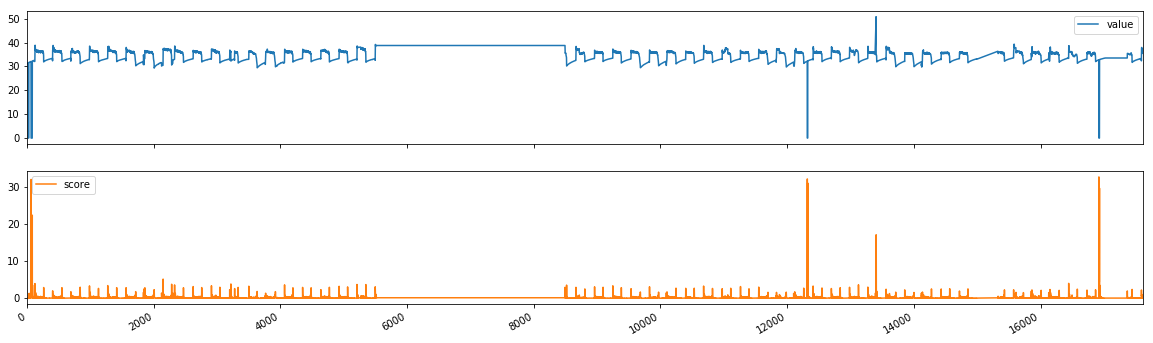

In [21]:
result.plot(figsize=[20,6], subplots=True)